### **LOAD DATA**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 9.8 MB 39.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
from google.colab import files
data_to_load = files.upload()

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# data setup
import io
df = pd.read_csv(io.BytesIO(data_to_load['gdp_model.csv']),parse_dates=["DATE"])
df.head()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base import  datetools


In [ ]:
df = pd.read_csv("gdp_model.csv", index_col=0, parse_dates=[0])
df.head()

### **SETTING FINAL GDPGR FORECAST**

In [ ]:
df2 = pd.read_csv(io.BytesIO(data_to_load['gdp_model.csv']),parse_dates=["DATE"])
df2.head()

In [ ]:
#convert columns to datetime and then to month period
df2['DATE'] = pd.to_datetime(df2['DATE']).dt.to_period('M')
df_series = df2.set_index('DATE').asfreq('M')
df_series

In [ ]:
# Final Target Variable Dataset
df_series = df2.set_index('DATE').asfreq('M')
series = pd.DataFrame(df_series['GDPGR'], index= df_series.index)
target_final = series.iloc[:,]
target_final.tail(5)

In [ ]:
# Holt Winter’s Exponential Smoothing or Triple Smoothing
# fit model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(series, trend = 'add',  seasonal_periods=None)
model_fit = model.fit()
# make prediction
GDPGR_Forecast = pd.DataFrame(model_fit.forecast(steps=10))
GDPGR_Forecast.columns = ['Holts-Winter Forecast']
GDPGR_Forecast

### **SET UP TRAIN-TEST**

In [ ]:
df_new = df.drop("GDPGR", axis=1)[:-1].copy()

In [ ]:
df_new["GDPGR"] = np.roll(df["GDPGR"], shift=-1)[:-1]

In [ ]:
X_train_roll = df_new[:180].drop("GDPGR", axis=1) #Period: 2005-02 to 2020-01 ~ Before Covid-19
X_train1_roll = df_new[:192].drop("GDPGR", axis=1) #Period:: 2005-2 to 2021-01 ~ Before Covid-19 and Vaccine
X_test_all_roll = df_new[180:].drop("GDPGR", axis=1) #Period: 2020-02 to 2021-12 ~ After Covid-19
X_test_bvac_roll = df_new[180:192].drop("GDPGR", axis=1) #Period: 2020-02 to 2021-01 ~ Before vaccination
X_test_avac_roll = df_new[192:].drop("GDPGR", axis=1) # Period: 2021-02 to 2021-12 ~ After vaccination

y_train_roll = df_new[:180]["GDPGR"]
y_train1_roll = df_new[:192]["GDPGR"]
y_test_all_roll = df_new[180:]["GDPGR"]
y_test_bvac_roll = df_new[180:192]["GDPGR"]
y_test_avac_roll = df_new[192:]["GDPGR"]

X_train_roll.shape, X_train1_roll.shape, X_test_all_roll.shape, X_test_bvac_roll.shape, X_test_avac_roll.shape

### **RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Set 1: All Covid-19
model_rrf1 = RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100)
model_rrf1.fit(X_train_roll, y_train_roll)

preds_rrf1 = model_rrf1.predict(X_test_all_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_rrf1 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_rrf1 )
print(f"MAE Score = {mae}")

#Forecast value
rrf1 = pd.DataFrame({'Random Forest Predicted': preds_rrf1[:]})
rrf1.index = y_test_all_roll.index
rrf1.head(5)

In [ ]:
#Set 2: Before vaccination
model_rrf2 = RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100)
model_rrf2.fit(X_train_roll, y_train_roll)

preds_rrf2 = model_rrf2.predict(X_test_bvac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_rrf2 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_rrf2 )
print(f"MAE Score = {mae}")

#Forecast value
rrf2 = pd.DataFrame({'Random Forest Predicted': preds_rrf2[:]})
rrf2.index = y_test_bvac_roll.index
rrf2.head(5)

In [ ]:
#Set 3: After vaccination
model_rrf3 = RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100)
model_rrf3.fit(X_train1_roll, y_train1_roll)

preds_rrf3 = model_rrf3.predict(X_test_avac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_rrf3 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_avac_roll, preds_rrf3)
print(f"MAE Score = {mae}")

#Forecast value
rrf3 = pd.DataFrame({'Random Forest Predicted': preds_rrf3[:]})
rrf3.index = y_test_avac_roll.index
rrf3.head(5)

In [ ]:
#Forecast value
forecast_rf = model_rrf1.predict(X_test_avac_roll)

rrf1a = pd.DataFrame({'Random Forest Forecast': forecast_rf[:10]})
rrf1a.index = GDPGR_Forecast.index
rrf1a.head()

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rrf1.plot(ax=ax, label='predictions')
rrf1a.plot(ax=ax, label ='forecast')

ax.legend();

### **XG BOOST**

In [ ]:
import xgboost as xgb

#Set 1: All Covid-19
model_rxg1 = xgb.XGBRegressor(n_estimators=100,max_depth = 8, min_child_weight = 1,gamma = 1,learning_rate = 0.1) 
model_rxg1.fit(X_train_roll, y_train_roll)

preds_rxg1 = model_rxg1.predict(X_test_all_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_rxg1))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_rxg1)
print(f"MAE Score = {mae}")

#Forecast value
rxg1 = pd.DataFrame({'XG Boost Predicted': preds_rxg1[:]})
rxg1.index = y_test_all_roll.index
rxg1.head(5)

In [ ]:
#Set 2: Before vaccination
model_rxg2 = xgb.XGBRegressor(n_estimators=100,max_depth = 8, min_child_weight = 1,gamma = 1,learning_rate = 0.1) 
model_rxg2.fit(X_train_roll, y_train_roll)

preds_rxg2 = model_rxg2.predict(X_test_bvac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_rxg2))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_rxg2)
print(f"MAE Score = {mae}")

#Forecast value
rxg2 = pd.DataFrame({'XG Boost Predicted': preds_rxg2[:]})
rxg2.index = y_test_bvac_roll.index
rxg2.head(5)

In [ ]:
#Set 3: After vaccination
model_rxg3 = xgb.XGBRegressor(n_estimators=100,max_depth = 8, min_child_weight = 1,gamma = 1,learning_rate = 0.1) 
model_rxg3.fit(X_train1_roll, y_train1_roll)

preds_rxg3 = model_rxg3.predict(X_test_avac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_rxg3))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_avac_roll, preds_rxg3)
print(f"MAE Score = {mae}")

#Forecast value
rxg3 = pd.DataFrame({'XG Boost Predicted': preds_rxg3[:]})
rxg3.index = y_test_avac_roll.index
rxg3.head(5)

In [ ]:
#Forecast value
forecast_rxg1 = model_rxg1.predict(X_test_avac_roll)

rxg1a = pd.DataFrame({'XG Boost Forecast': forecast_rxg1[:10]})
rxg1a.index = GDPGR_Forecast.index
rxg1a.head()

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rxg1.plot(ax=ax, label='predictions')
rxg1a.plot(ax=ax, label ='forecast')

ax.legend();

## **COMPILE LATEST FORECAST**

In [ ]:
#Forecasted Value
result_forecast = pd.concat([GDPGR_Forecast,rxg1a,rrf1a],1)
result_forecast.plot()
result_forecast.head(5)


In [ ]:
from google.colab import files
result_forecast.to_csv('result_Q3Q4.csv') 
files.download('result_Q3Q4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **OTHER MODELS**

### **LIGHTGBM**

In [ ]:
import lightgbm
from sklearn.metrics import mean_absolute_error

#Set 1:All Covid-19
model_rlgbm1 = lightgbm.LGBMRegressor()
model_rlgbm1.fit(X_train_roll, y_train_roll)

preds_rlgbm_s1 = model_lgbm1.predict(X_test_all_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_rlgbm_s1))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_rlgbm_s1)
print(f"MAE Score = {mae}")

#mda = np.mean((np.sign(y_test_all[1:] - y_test_all[:-1]) == np.sign(preds_lgbm_s1[1:] - preds_lgbm_s1[:-1])).astype(int))
#print(f"MDA Score = {mda}")

#Forecast value
rlgbm_s1 = pd.DataFrame({'Light GBM Predicted': preds_rlgbm_s1[:]})
rlgbm_s1.index = y_test_all_roll.index
rlgbm_s1.head(5)


In [ ]:
#Set 2: Before vaccination
model_rlgbm2 = lightgbm.LGBMRegressor()
model_rlgbm2.fit(X_train_roll, y_train_roll)

preds_rlgbm_s2 = model_rlgbm2.predict(X_test_bvac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_rlgbm_s2))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_rlgbm_s2)
print(f"MAE Score = {mae}")

#Forecast value
rlgbm_s2 = pd.DataFrame({'Light GBM Predicted': preds_rlgbm_s2[:]})
rlgbm_s2.index = y_test_bvac_roll.index
rlgbm_s2.head(5)

In [ ]:
#Set 3: After vaccination
model_rlgbm3 = lightgbm.LGBMRegressor()
model_rlgbm3.fit(X_train1_roll, y_train1_roll)

preds_rlgbm_s3 = model_rlgbm3.predict(X_test_avac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_rlgbm_s3))
print(f"RMSE Score = {rmse}")

mae = mae = mean_absolute_error(y_test_avac_roll, preds_rlgbm_s3)
print(f"MAE Score = {mae}")

#Forecast value
rlgbm_s3 = pd.DataFrame({'Light GBM Predicted': preds_rlgbm_s3[:]})
rlgbm_s3.index = y_test_avac_roll.index
rlgbm_s3.head(5)

In [ ]:
#Forecast value
forecast_rlgbm = model_rlgbm1.predict(X_test_avac_roll)

rlgbm_s1a = pd.DataFrame({'Light GBM Forecast': forecast_rlgbm[:10]})
rlgbm_s1a.index = GDPGR_Forecast.index
rlgbm_s1a.head()

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rlgbm_s1.plot(ax=ax, label='predictions')
rlgbm_s1a.plot(ax=ax, label ='forecast')

ax.legend();

### **LASSO REGRESSION**

In [ ]:
from sklearn.linear_model import Lasso

model_rlas1 = Lasso()
model_rlas1.fit(X_train_roll, y_train_roll)

#Set 1: All Covid-19
preds_rlas_s1 = model_rlas1.predict(X_test_all_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_rlas_s1))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_rlas_s1)
print(f"MAE Score = {mae}")

#Forecast value
rlas_s1 = pd.DataFrame({'Lasso Predicted': preds_rlas_s1[:]})
rlas_s1.index = y_test_all_roll.index
rlas_s1.head(5)

In [ ]:
#Set 2: Before vaccination
model_rlas2 = Lasso()
model_rlas2.fit(X_train_roll, y_train_roll)

preds_rlas_s2 = model_rlas2.predict(X_test_bvac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_rlas_s2))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_rlas_s2)
print(f"MAE Score = {mae}")

#Forecast value
rlas_s2 = pd.DataFrame({'Lasso Predicted': preds_rlas_s2[:]})
rlas_s2.index = y_test_bvac_roll.index
rlas_s2.head(5)

In [ ]:
#Set 3: After vaccination
model_rlas3 = Lasso()
model_rlas3.fit(X_train1_roll, y_train1_roll)

preds_rlas_s3 = model_rlas3.predict(X_test_avac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_rlas_s3))
print(f"RMSE Score = {rmse}")

mae =mean_absolute_error(y_test_avac_roll, preds_rlas_s3)
print(f"MAE Score = {mae}")

#Forecast value
rlas_s3 = pd.DataFrame({'Lasso Predicted': preds_rlas_s3[:]})
rlas_s3.index = y_test_avac_roll.index
rlas_s3.head(5)


In [ ]:
#Forecast value
forecast_rlas = model_rlas1.predict(X_test_avac_roll)

rlas_s1a = pd.DataFrame({'Lasso Forecast': forecast_rlas[:10]})
rlas_s1a.index = GDPGR_Forecast.index
rlas_s1a.head()

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rlas_s1.plot(ax=ax, label='predictions')
rlas_s1a.plot(ax=ax, label ='forecast')

ax.legend();

### **RIDGE REGRESSION**

In [ ]:
from sklearn.linear_model import Ridge

model_rri1 = Ridge()
model_rri1.fit(X_train_roll, y_train_roll)

#Set 1: All covid-19
preds_rri_s1 = model_rri1.predict(X_test_all_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_rri_s1))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_rri_s1)
print(f"MAE Score = {mae}")

#Forecast value
rri_s1 = pd.DataFrame({'Ridge Predicted': preds_rri_s1[:]})
rri_s1.index = y_test_all_roll.index
rri_s1.head(5)

RMSE Score = 6.783964391539895
MAE Score = 4.991153903322463


,Ridge Predicted
DATE,
2020-02-01,6.755281
2020-03-01,1.724840
2020-04-01,8.584533
2020-05-01,3.482997
2020-06-01,5.406185


In [ ]:
#Set 2: Before vaccination
model_rri2 = Ridge()
model_rri2.fit(X_train_roll, y_train_roll)

preds_rri_s2 = model_rri2.predict(X_test_bvac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_rri_s2))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_rri_s2)
print(f"MAE Score = {mae}")

#Forecast value
rri_s2 = pd.DataFrame({'Ridge Predicted': preds_rri_s2[:]})
rri_s2.index = y_test_bvac_roll.index
rri_s2.head(5)

RMSE Score = 7.495174881919297
MAE Score = 5.255777747963509


,Ridge Predicted
DATE,
2020-02-01,6.755281
2020-03-01,1.724840
2020-04-01,8.584533
2020-05-01,3.482997
2020-06-01,5.406185


In [ ]:
#Set 3: After vaccination
model_rri3 = Ridge()
model_rri3.fit(X_train1_roll, y_train1_roll)

preds_rri_s3 = model_rri2.predict(X_test_avac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_rri_s3))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_avac_roll, preds_rri_s3)
print(f"MAE Score = {mae}")

#Forecast value
rri_s3 = pd.DataFrame({'Ridge Forecast': preds_rri_s3[:]})
rri_s3.index = y_test_avac_roll.index
rri_s3.head(5)

RMSE Score = 5.816838014921338
MAE Score = 4.673605289753207


,Ridge Forecast
DATE,
2021-02-01,6.840128
2021-03-01,3.626250
2021-04-01,5.867856
2021-05-01,4.110747
2021-06-01,4.026107


In [ ]:
#Forecast value
forecast_rri = model_rri1.predict(X_test_avac_roll)

rri_s1a = pd.DataFrame({'XG Boost Forecast': forecast_rri[:10]})
rri_s1a.index = GDPGR_Forecast.index
rri_s1a.head()

,XG Boost Forecast
2022-01,6.840128
2022-02,3.626250
2022-03,5.867856
2022-04,4.110747
2022-05,4.026107


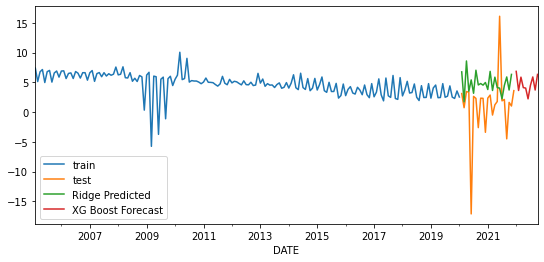

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rri_s1.plot(ax=ax, label='predictions')
rri_s1a.plot(ax=ax, label ='forecast')

ax.legend();

### **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

model_rknn1 = KNeighborsRegressor()
model_rknn1.fit(X_train_roll, y_train_roll)

#Set 1: All covid-19
preds_rknn_s1 = model_knn1.predict(X_test_all_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_rknn_s1))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_rknn_s1)
print(f"MAE Score = {mae}")

#Forecast value
rknn_s1 = pd.DataFrame({'KNN Predicted': preds_rknn_s1[:]})
rknn_s1.index = y_test_all_roll.index
rknn_s1.head(5)

RMSE Score = 6.9016534344656515
MAE Score = 4.840332470736363


,KNN Predicted
DATE,
2020-02-01,5.303738
2020-03-01,2.455032
2020-04-01,4.501928
2020-05-01,5.647924
2020-06-01,3.652287


In [ ]:
#Set 2: Before vaccination
model_rknn2 = KNeighborsRegressor()
model_rknn2.fit(X_train_roll, y_train_roll)

preds_rknn_s2 = model_rknn2.predict(X_test_bvac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_rknn_s2))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_rknn_s2)
print(f"MAE Score = {mae}")

#Forecast value
rknn_s2 = pd.DataFrame({'KNN Predicted': preds_rknn_s2[:]})
rknn_s2.index = y_test_bvac_roll.index
rknn_s2.head(5)

RMSE Score = 7.411153997023467
MAE Score = 4.55939350865


,KNN Predicted
DATE,
2020-02-01,5.444536
2020-03-01,4.157992
2020-04-01,4.605059
2020-05-01,5.142514
2020-06-01,3.320611


In [ ]:
#Set 3: After vaccination
model_rknn3 = KNeighborsRegressor()
model_rknn3.fit(X_train1_roll, y_train1_roll)

preds_rknn_s3 = model_rknn3.predict(X_test_avac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_rknn_s3))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_avac_roll, preds_rknn_s3)
print(f"MAE Score = {mae}")

#Forecast value
rknn_s3 = pd.DataFrame({'KNN Predicted': preds_rknn_s3[:]})
rknn_s3.index = y_test_avac_roll.index
rknn_s3.head(5)

RMSE Score = 5.516370230068229
MAE Score = 4.248442154619999


,KNN Predicted
DATE,
2021-02-01,2.314881
2021-03-01,4.577878
2021-04-01,4.721047
2021-05-01,4.248499
2021-06-01,4.524693


In [ ]:
#Forecast value
forecast_rknn = model_rknn1.predict(X_test_avac_roll)

rknn_s1a = pd.DataFrame({'XG Boost Forecast': forecast_rknn[:10]})
rknn_s1a.index = GDPGR_Forecast.index
rknn_s1a.head()

,XG Boost Forecast
2022-01,2.950931
2022-02,4.577878
2022-03,4.721047
2022-04,4.709517
2022-05,4.995690


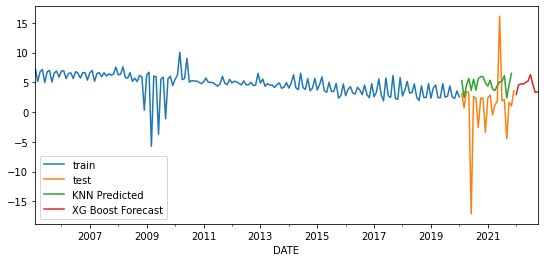

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rknn_s1.plot(ax=ax, label='predictions')
rknn_s1a.plot(ax=ax, label ='forecast')

ax.legend();

### **PROPHET MULTIVARIATE**

In [ ]:
from fbprophet import Prophet

X_train_prophet = X_train_roll.copy()
X_train1_prophet = X_train1_roll.copy()
X_test_all_prophet = X_test_all_roll.copy()
X_test_bvac_prophet = X_test_bvac_roll.copy()
X_test_avac_prophet = X_test_avac_roll.copy()

y_train_prophet = y_train_roll.copy()
y_train1_prophet = y_train1_roll.copy()
y_test_all_prophet = y_test_all_roll.copy()
y_test_bvac_prophet = y_test_bvac_roll.copy()
y_test_avac_prophet = y_test_avac_roll.copy()

X_train_prophet["ds"] = X_train_prophet.index
X_train_prophet["y"] = y_train_prophet.values

X_train1_prophet["ds"] = X_train1_prophet.index
X_train1_prophet["y"] = y_train1_prophet.values

X_test_all_prophet["ds"] = X_test_all_prophet.index
X_test_all_prophet["y"] = y_test_all_prophet.values

X_test_bvac_prophet["ds"] = X_test_bvac_prophet.index
X_test_bvac_prophet["y"] = y_test_bvac_prophet.values

X_test_avac_prophet["ds"] = X_test_avac_prophet.index
X_test_avac_prophet["y"] = y_test_avac_prophet.values

#Set 1: All Covid-19
prophet1 = Prophet()

for col in X_train_prophet.columns:
    if col not in ["ds", "y"]:
        prophet1.add_regressor(col)

prophet1.fit(X_train_prophet)

yhat = prophet1.predict(X_test_all_prophet)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, yhat.yhat))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, yhat.yhat)
print(f"MAE Score = {mae}")

#Forecast value
rprop_s1 = pd.DataFrame({'Prophet Predicted': yhat.yhat[:]})
rprop_s1.index = y_test_all_roll.index
rprop_s1.head(5)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Score = 6.244603878566978
MAE Score = 3.8998833994842967


,Prophet Predicted
DATE,
2020-02-01,5.486883
2020-03-01,2.402267
2020-04-01,10.513761
2020-05-01,3.093278
2020-06-01,2.551381


In [ ]:
#Set 2: Before vaccination
prophet2 = Prophet()

for col in X_train_prophet.columns:
    if col not in ["ds", "y"]:
        prophet2.add_regressor(col)

prophet2.fit(X_train_prophet)

yhat = prophet2.predict(X_test_bvac_prophet)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, yhat.yhat))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, yhat.yhat)
print(f"MAE Score = {mae}")

#Forecast value
rprop_s2 = pd.DataFrame({'Prophet Predicted': yhat.yhat[:]})
rprop_s2.index = y_test_bvac_roll.index
rprop_s2.head(5)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Score = 7.103113318965527
MAE Score = 4.464092439575327


,Prophet Predicted
DATE,
2020-02-01,5.486883
2020-03-01,2.402267
2020-04-01,10.513761
2020-05-01,3.093278
2020-06-01,2.551381


In [ ]:
#Set 3: After vaccination
prophet3 = Prophet()

for col in X_train1_prophet.columns:
    if col not in ["ds", "y"]:
        prophet3.add_regressor(col)

prophet3.fit(X_train1_prophet)

yhat = prophet3.predict(X_test_avac_prophet)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, yhat.yhat))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_avac_roll, yhat.yhat)
print(f"MAE Score = {mae}")

#Forecast value
rprop_s3 = pd.DataFrame({'Prophet Predicted': yhat.yhat[:]})
rprop_s3.index = y_test_avac_roll.index
rprop_s3.head(5)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Score = 5.445952315003144
MAE Score = 3.552597746518259


,Prophet Predicted
DATE,
2021-02-01,2.817493
2021-03-01,1.510267
2021-04-01,5.071988
2021-05-01,1.576256
2021-06-01,7.230485


In [ ]:
#Forecast value
yhat = prophet1.predict(X_test_avac_prophet)

rprop_s1a = pd.DataFrame({'Prophet Forecast': yhat.yhat[:10]})
rprop_s1a.index = GDPGR_Forecast.index
rprop_s1a.head()

,Prophet Forecast
2022-01,4.333863
2022-02,1.570016
2022-03,2.863170
2022-04,3.168306
2022-05,2.182668


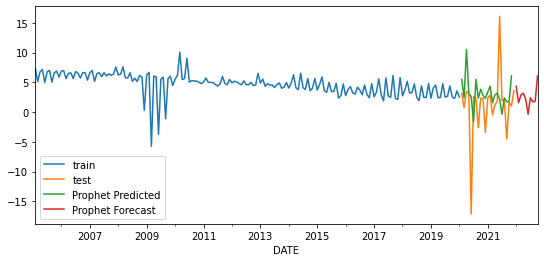

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rprop_s1.plot(ax=ax, label='predictions')
rprop_s1a.plot(ax=ax, label ='forecast')

ax.legend();

### **ELASTIC NET REGRESSION**

In [ ]:
from sklearn.linear_model import ElasticNet

#Set 1:All Covid-19
model_ren1 = ElasticNet()
model_ren1.fit(X_train_roll, y_train_roll)

preds_ren_s1 = model_en1.predict(X_test_all_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_ren_s1 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_ren_s1 )
print(f"MAE Score = {mae}")

#Forecast value
ren_s1 = pd.DataFrame({'Elastic Net Predicted': preds_ren_s1[:]})
ren_s1.index = y_test_all_roll.index
ren_s1.head(5)

RMSE Score = 6.528278674553842
MAE Score = 4.674036863242498


,Elastic Net Predicted
DATE,
2020-02-01,3.970253
2020-03-01,5.008523
2020-04-01,8.206447
2020-05-01,3.905931
2020-06-01,3.679308


In [ ]:
#Set 2: Before vaccination
model_ren2 = ElasticNet()
model_ren2.fit(X_train_roll, y_train_roll)

preds_ren_s2 = model_ren2.predict(X_test_bvac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_ren_s2 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_ren_s2 )
print(f"MAE Score = {mae}")

#Forecast value
ren_s2 = pd.DataFrame({'Elastic Predicted': preds_ren_s2[:]})
ren_s2.index = y_test_bvac_roll.index
ren_s2.head(5)

RMSE Score = 7.588219551154524
MAE Score = 4.882575984200843


,Elastic Predicted
DATE,
2020-02-01,6.029778
2020-03-01,4.462299
2020-04-01,4.240447
2020-05-01,5.033076
2020-06-01,3.994175


In [ ]:
#Set 3: After vaccination
model_ren3 = ElasticNet()
model_ren3.fit(X_train1_roll, y_train1_roll)

preds_ren_s3 = model_ren3.predict(X_test_avac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_ren_s3 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_avac_roll, preds_ren_s3 )
print(f"MAE Score = {mae}")

#Forecast value
ren_s3 = pd.DataFrame({'Elastic Net Predicted': preds_ren_s3[:]})
ren_s3.index = y_test_avac_roll.index
ren_s3.head(5)

RMSE Score = 5.7413728886767545
MAE Score = 4.949702578893264


,Elastic Net Predicted
DATE,
2021-02-01,4.554904
2021-03-01,4.397271
2021-04-01,6.541606
2021-05-01,4.236423
2021-06-01,4.079062


In [ ]:
#Forecast value
forecast_en = model_ren1.predict(X_test_avac_roll)

ren_s1a = pd.DataFrame({'Elastic Net Forecast': forecast_en[:10]})
ren_s1a.index = GDPGR_Forecast.index
ren_s1a.head()

,Elastic Net Forecast
2022-01,5.206603
2022-02,4.261943
2022-03,5.118382
2022-04,5.283048
2022-05,4.484492


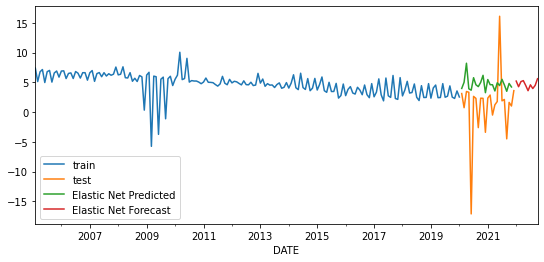

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
ren_s1.plot(ax=ax, label='predictions')
ren_s1a.plot(ax=ax, label ='forecast')

ax.legend();

### **DECISION TREE**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

#Set 1: During Covid-19
model_rdt1 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
model_rdt1.fit(X_train_roll, y_train_roll)

preds_rdt1 = model_rdt1.predict(X_test_all_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_rdt1 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_rdt1)
print(f"MAE Score = {mae}")

#Forecast value
rdt1 = pd.DataFrame({'Decision Tree Predicted': preds_rdt1[:]})
rdt1.index = y_test_all_roll.index
rdt1.head(5)


RMSE Score = 6.727032634979117
MAE Score = 4.731910735906512


,Decision Tree Predicted
DATE,
2020-02-01,6.114776
2020-03-01,4.674483
2020-04-01,6.114776
2020-05-01,5.481860
2020-06-01,3.340265


In [ ]:
#Set 2: Before vaccination
model_rdt2 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
model_rdt2.fit(X_train_roll, y_train_roll)

preds_rdt2 = model_rdt2.predict(X_test_bvac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_rdt2 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_rdt2)
print(f"MAE Score = {mae}")

#Forecast value
rdt2 = pd.DataFrame({'Decision Tree Predicted': preds_rdt2[:]})
rdt2.index = y_test_bvac_roll.index
rdt2.head(5)

RMSE Score = 7.630299222652167
MAE Score = 4.931397085061692


,Decision Tree Predicted
DATE,
2020-02-01,6.114776
2020-03-01,4.674483
2020-04-01,6.114776
2020-05-01,5.481860
2020-06-01,3.340265


In [ ]:
#Set 3: After vaccination
model_rdt3 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
model_rdt3.fit(X_train1_roll, y_train1_roll)

preds_rdt3 = model_rdt3.predict(X_test_avac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_rdt3 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_avac_roll, preds_rdt3)
print(f"MAE Score = {mae}")

#Forecast value
rdt3 = pd.DataFrame({'Decision Tree Predicted': preds_rdt3[:]})
rdt3.index = y_test_avac_roll.index
rdt3.head(5)

RMSE Score = 5.844825086902434
MAE Score = 4.88633963421571


,Decision Tree Predicted
DATE,
2021-02-01,5.319238
2021-03-01,5.319238
2021-04-01,5.319238
2021-05-01,4.863523
2021-06-01,4.863523


In [ ]:
#Forecast value
forecast_rdt1 = model_rdt1.predict(X_test_avac_roll)

rdt1a = pd.DataFrame({'Decision Tree Forecast': forecast_rdt1[:10]})
rdt1a.index = GDPGR_Forecast.index
rdt1a.head()

,Decision Tree Forecast
2022-01,3.804148
2022-02,5.481860
2022-03,3.340265
2022-04,5.005450
2022-05,5.005450


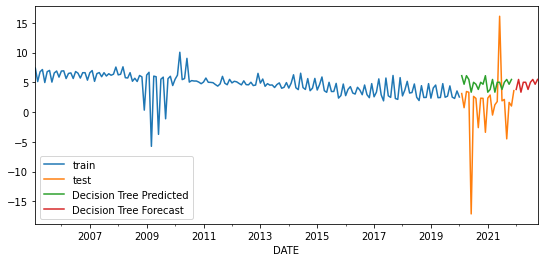

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rdt1.plot(ax=ax, label='predictions')
rdt1a.plot(ax=ax, label ='forecast')

ax.legend();

### **SUPPORT VECTOR MACHINE**

In [ ]:
from sklearn.svm import SVR

#Set 1: All Covid-19
model_rsvr1 = SVR(kernel= 'rbf')
model_rsvr1.fit(X_train_roll, y_train_roll)

preds_rsvr1 = model_rsvr1.predict(X_test_all_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_rsvr1 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_rsvr1 )
print(f"MAE Score = {mae}")

#Forecast value
rsvr1 = pd.DataFrame({'SVM Predicted': preds_rsvr1 [:]})
rsvr1.index = y_test_all_roll.index
rsvr1.head(5)


RMSE Score = 6.708741073419224
MAE Score = 4.7623837803501745


,SVM Predicted
DATE,
2020-02-01,5.388648
2020-03-01,4.654350
2020-04-01,4.567007
2020-05-01,4.832068
2020-06-01,3.566721


In [ ]:
#Set 2: Before Vaccination
model_rsvr2 = SVR(kernel= 'rbf')
model_rsvr2.fit(X_train_roll, y_train_roll)

preds_rsvr2 = model_rsvr2.predict(X_test_bvac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_rsvr2 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_rsvr2 )
print(f"MAE Score = {mae}")

#Forecast value
rsvr2 = pd.DataFrame({'SVM Predicted': preds_rsvr2 [:]})
rsvr2.index = y_test_bvac_roll.index
rsvr2.head(5)


RMSE Score = 7.41979647335508
MAE Score = 4.811609113920456


,SVM Predicted
DATE,
2020-02-01,5.388648
2020-03-01,4.654350
2020-04-01,4.567007
2020-05-01,4.832068
2020-06-01,3.566721


In [ ]:
#Set 3: After Vaccination
model_rsvr3 = SVR(kernel= 'rbf')
model_rsvr3.fit(X_train1_roll, y_train1_roll)

preds_rsvr3 = model_rsvr3.predict(X_test_avac_roll)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_rsvr3 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_avac_roll, preds_rsvr3 )
print(f"MAE Score = {mae}")

#Forecast value
rsvr3 = pd.DataFrame({'SVM Predicted': preds_rsvr3 [:]})
rsvr3.index = y_test_avac_roll.index
rsvr3

RMSE Score = 5.622124996247836
MAE Score = 4.485819738685776


,SVM Predicted
DATE,
2021-02-01,4.891379
2021-03-01,3.842681
2021-04-01,3.688412
2021-05-01,4.376884
2021-06-01,4.999074
2021-07-01,5.336442
2021-08-01,5.580735
2021-09-01,4.032387
2021-10-01,4.206754


In [ ]:
#Forecast value
forecast_rsvr1 = model_rsvr1.predict(X_test_avac_roll)

rsvr1a = pd.DataFrame({'SVM Forecast': forecast_rsvr1[:10]})
rsvr1a.index = GDPGR_Forecast.index
rsvr1a.head()

,SVM Forecast
2022-01,5.181120
2022-02,4.189197
2022-03,4.130968
2022-04,4.471214
2022-05,5.109505


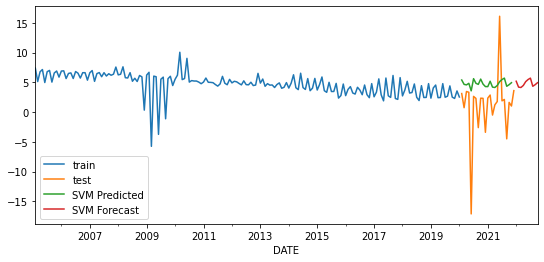

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rsvr1.plot(ax=ax, label='predictions')
rsvr1a.plot(ax=ax, label ='forecast')

ax.legend();

### **DEEP LEARNING -LSTM**

In [ ]:
import tensorflow as tf

BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24

def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, 
    so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)

#Set 1: All Covid-19

#To join the datasets again of train and test
X_w = np.concatenate((X_train_roll, X_test_all_roll))
y_w = np.concatenate((y_train_roll, y_test_all_roll))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test_all_roll)]
y_train_w = y_w[:-len(X_test_all_roll)]
X_test_w = X_w[-len(X_test_all_roll):]
y_test_w = y_w[-len(X_test_all_roll):]

# Check same test set as in the previous models to ensure didn't screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test_all_roll)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

dropout = 0.0
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='rmsprop', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 15

model_history = model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  

preds_rlstm_s1 = model.predict(X_test_w).reshape(1, -1)[0]

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_all_roll, preds_rlstm_s1 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_all_roll, preds_rlstm_s1 )
print(f"MAE Score = {mae}")

#Forecast value
rlstm_s1 = pd.DataFrame({'LSTM Predicted': preds_rlstm_s1[:]})
rlstm_s1.index = y_test_all_roll.index
rlstm_s1.head(5)

In [ ]:
#Set 2: Before vaccination

# To join the datasets again of train and test
X_w = np.concatenate((X_train_roll, X_test_bvac_roll))
y_w = np.concatenate((y_train_roll, y_test_bvac_roll))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test_bvac_roll)]
y_train_w = y_w[:-len(X_test_bvac_roll)]
X_test_w = X_w[-len(X_test_bvac_roll):]
y_test_w = y_w[-len(X_test_bvac_roll):]

# Check same test set as in the previous models to ensure didn't screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test_bvac_roll)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

dropout = 0.0
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='rmsprop', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 15

model_history = model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  

preds_rlstm_s2 = model.predict(X_test_w).reshape(1, -1)[0]

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_bvac_roll, preds_rlstm_s2 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_bvac_roll, preds_rlstm_s2 )
print(f"MAE Score = {mae}")

#Forecast value
rlstm_s2 = pd.DataFrame({'LSTM Predicted': preds_rlstm_s2[:]})
rlstm_s2.index = y_test_bvac_roll.index
rlstm_s2.head(5)

In [ ]:
#Set 3: After vaccination

# To join the datasets again of train and test
X_w = np.concatenate((X_train1_roll, X_test_avac_roll))
y_w = np.concatenate((y_train1_roll, y_test_avac_roll))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test_avac_roll)]
y_train_w = y_w[:-len(X_test_avac_roll)]
X_test_w = X_w[-len(X_test_avac_roll):]
y_test_w = y_w[-len(X_test_avac_roll):]

# Check same test set as in the previous models to ensure didn't screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test_avac_roll)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

dropout = 0.0
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='rmsprop', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 15

model_history = model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  

preds_rlstm_s3 = model.predict(X_test_w).reshape(1, -1)[0]

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test_avac_roll, preds_rlstm_s3 ))
print(f"RMSE Score = {rmse}")

mae = mean_absolute_error(y_test_avac_roll, preds_rlstm_s3 )
print(f"MAE Score = {mae}")

#Forecast value
rlstm_s3 = pd.DataFrame({'LSTM Predicted': preds_rlstm_s3[:]})
rlstm_s3.index = y_test_avac_roll.index
rlstm_s3.head(5)

In [ ]:
X_test_w1 = X_w[-len(X_test_avac_roll):]
forecast_rlstm_s1 = model.predict(X_test_w1).reshape(1, -1)[0]

#Forecast value
rlstm_s1a = pd.DataFrame({'LSTM Forecast': forecast_rlstm_s1[:10]})
rlstm_s1a.index = GDPGR_Forecast.index
rlstm_s1a.head(5)

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
rlstm_s1.plot(ax=ax, label='predictions')
rlstm_s1a.plot(ax=ax, label ='forecast')

ax.legend();

### **COMBINE ALL FORECAST**

In [ ]:
#Set 1: All Covid-19
Final_rpredicted1 = pd.concat([y_test_all_roll,ar1,rsvr1, rxg1, rdt1, rrf1, ren_s1, rri_s1, rlas_s1, rlstm_s1, rprop_s1, rknn_s1, rlgbm_s1],1)
Final_rpredicted1.plot()
Final_rpredicted1.head(5)


In [ ]:
from google.colab import files
Final_rpredicted1.to_csv('final_predicted-rolling set 1.csv') 
files.download('final_predicted-rolling set 1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Set 2: Before vaccination
Final_rpredicted2 = pd.concat([y_test_bvac_roll,ar2,rsvr2, rxg2, rdt2, rrf2, ren_s2, rri_s2, rlas_s2, rlstm_s2, rprop_s2, rknn_s2, rlgbm_s2],1)
Final_rpredicted2.plot()
Final_rpredicted2.head(5)


In [ ]:
from google.colab import files
Final_rpredicted2.to_csv('final_predicted-rolling set 2.csv') 
files.download('final_predicted-rolling set 2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Set 3: After vaccination
Final_rpredicted3 = pd.concat([y_test_avac_roll,ar3,rsvr3, rxg3, rdt3, rrf3, ren_s3, rri_s3, rlas_s3, rlstm_s3, rprop_s3, rknn_s3, rlgbm_s3],1)
Final_rpredicted3.plot()
Final_rpredicted3.head(5)

In [ ]:
from google.colab import files
Final_rpredicted3.to_csv('final_predicted-rolling set 3.csv') 
files.download('final_predicted-rolling set 3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Forecasted Value
Final_forecasted1 = pd.concat([GDPGR_Forecast,ar1a,rsvr1a, rxg1a, rdt1a, rrf1a, ren_s1a, rri_s1a, rlas_s1a, rlstm_s1a, rprop_s1a, rknn_s1a, rlgbm_s1a],1)
Final_forecasted1.plot()
Final_forecasted1.head(5)

#Final_forecasted2.head()

In [ ]:
from google.colab import files
Final_forecasted1.to_csv('final_forecasted-rolling.csv') 
files.download('final_forecasted-rolling.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Auto Regressive (AR)**

In [ ]:
# Set one: Before and All Covid-19 
from statsmodels.tsa.ar_model import AutoReg

#Create training and test data
train_data1 = df[:180]["GDPGR"]
test_data1 = df[180:]["GDPGR"]

# Instantiate and fit the AR model with training data
ar_model1 = AutoReg(train_data1, lags=8).fit()

# Print Summary
print(ar_model1.summary())

# Make the predictions
pred_ar1_train = ar_model1.predict(start=len(train_data1), end=(len(df)-1), dynamic=False)
pred_ar1_test = ar_model1.predict(start=len(test_data1), end=(len(df)-1), dynamic=False)

In [ ]:
# Set one: Before and All Covid-19 
from statsmodels.tsa.ar_model import AutoReg

#Create training and test data
train_data1 = df[:180]["GDPGR"]
test_data1 = df[180:]["GDPGR"]

# Instantiate and fit the AR model with training data
ar_model1 = AutoReg(train_data1, lags=8).fit()

# Print Summary
print(ar_model1.summary())

# Make the predictions
pred_ar1_train = ar_model1.predict(start=len(test_data1), end=(len(df)-1), dynamic=False)
pred_ar1_test = ar_model1.predict(start=len(train_data1), end=(len(df)-1), dynamic=False)

# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.plot(pred_ar1_train, color = 'green')
pyplot.plot(pred_ar1_test, color = 'blue')
pyplot.plot(test_data1, color='red')

# Performance metrics
rmse_train = np.sqrt(mean_squared_error(train_data1, pred_ar1_train))
print(f"RMSE Score Train = {rmse_train}")
rmse_test = np.sqrt(mean_squared_error(test_data1, pred_ar1_test))
print(f"RMSE Score Test = {rmse_test}")

mae_train = mean_absolute_error(train_data1, pred_ar1_train)
print(f"MAE Score Train = {mae_train}")
mae_test = mean_absolute_error(test_data1, pred_ar1_test)
print(f"MAE Score Test = {mae_test}")

# Predicted value - train 
ar1_train = pd.DataFrame({'AR Model Predicted': pred_ar1_train[:]})
ar1_train.index = train_data1.index
ar1_train.head()


In [ ]:
# Predicted value - test 
ar1_test = pd.DataFrame({'AR Model Predicted': pred_ar1_test[:]})
ar1_test.index = test_data1.index
ar1_test.head()


In [ ]:
# Set Two: Before Covid and Vaccination 
from statsmodels.tsa.ar_model import AutoReg

#Create training and test data
train_data2 = df[:180]["GDPGR"]
test_data2 = df[180:192]["GDPGR"]

# Instantiate and fit the AR model with training data
ar_model2 = AutoReg(train_data2, lags=4).fit()

# Print Summary
print(ar_model2.summary())

# Make the predictions
pred_ar2_train = ar_model2.predict(start=len(test_data2), end=len(df)-12, dynamic=False)
pred_ar2_test = ar_model2.predict(start=len(train_data2), end=len(df)-12, dynamic=False)

# Plot the prediction vs test data

from matplotlib import pyplot
pyplot.plot(pred_ar2_train, color = 'green')
pyplot.plot(pred_ar2_test, color = 'blue')
pyplot.plot(test_data2, color='red')

# Performance metrics
rmse_train = np.sqrt(mean_squared_error(train_data2, pred_ar2_train))
print(f"RMSE Score Train= {rmse_train}")
rmse_test = np.sqrt(mean_squared_error(test_data2, pred_ar2_test))
print(f"RMSE Score Test = {rmse_test}")

mae_train = mean_absolute_error(train_data2, pred_ar2_train)
print(f"MAE Score = {mae_train}")
mae_test = mean_absolute_error(test_data2, pred_ar2_test)
print(f"MAE Score = {mae_test}")

# Predicted value -train 
ar2_train = pd.DataFrame({'AR Model Predicted': pred_ar2_train[:]})
ar2_train.index = train_data2.index
ar2_train.head()


In [ ]:
# Predicted value -train 
ar2_test = pd.DataFrame({'AR Model Predicted': pred_ar2_test[:]})
ar2_test.index = test_data2.index
ar2_test.head()


In [ ]:
# Set Three: Before Covid and After Vaccination 
from statsmodels.tsa.ar_model import AutoReg

#Create training and test data
train_data3 = df[:192]["GDPGR"]
test_data3 = df[192:]["GDPGR"]

# Instantiate and fit the AR model with training data
ar_model3 = AutoReg(train_data3, lags=4).fit()

# Print Summary
print(ar_model3.summary())

# Make the predictions
pred_ar3_train = ar_model3.predict(start=len(test_data3), end=len(df)-1, dynamic=False)
pred_ar3_test = ar_model3.predict(start=len(train_data3), end=len(df)-1, dynamic=False)

# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.plot(train_data3, color = 'orange')
pyplot.plot(pred_ar3_train, color = 'green')
pyplot.plot(pred_ar3_test, 'blue')
pyplot.plot(test_data3, color='red')

# Performance metrics
rmse_train = np.sqrt(mean_squared_error(train_data3, pred_ar3_train))
print(f"RMSE Score Train = {rmse_train}")
rmse_test = np.sqrt(mean_squared_error(test_data3, pred_ar3_test))
print(f"RMSE Score Train = {rmse_test}")

mae_train = mean_absolute_error(train_data3, pred_ar3_train)
print(f"MAE Score = {mae_train}")
mae_test = mean_absolute_error(test_data3, pred_ar3_test)
print(f"MAE Score = {mae_test}")

# Predicted value - train
ar3_train = pd.DataFrame({'AR Model Predicted': pred_ar3_train[:]})
ar3_train.index = train_data3.index
ar3_train.head()



In [ ]:
# Predicted value
ar3_test = pd.DataFrame({'AR Model Predicted': pred_ar3_test[:]})
ar3_test.index = test_data3.index
ar3_test.head()

In [ ]:
#Forecast value
forecast_ar = ar_model1.predict(start=len(test_data3), end=(len(df)-1), dynamic=False)

ar1a = pd.DataFrame({'AR Model Forecasted': pred_ar1_test[:10]})
ar1a.index = GDPGR_Forecast.index
ar1a.head()

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test_all.plot(ax=ax, label='test')
ar1.plot(ax=ax, label='predictions')
ar1a.plot(ax=ax, label ='forecast')

ax.legend();